In [24]:
import pygmt
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
from pyproj import CRS, Transformer
from shapely.geometry import Polygon, MultiPolygon, LineString, MultiLineString
import os, h5py

quickplot = False # boolean to speed up plotting when developing
#out='Figure1-Map.png' # Name the output file
out='hills-grl-fig1-map.pdf'

In [25]:
# Quick geodetic to PS71 converter from pyproj
def ll2xy(lon, lat):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Antarctic Polar Stereograph coordinates (x, y)
    
    x, y = ps2ll(lon, lat)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

def xy2ll(x,y):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Antarctic Polar Stereograph coordinates (x, y)
    
    x, y = ps2ll(lon, lat)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    xy_to_ll = Transformer.from_crs(crs_xy, crs_ll, always_xy = True)
    lon, lat = xy_to_ll.transform(x, y)
    return lon, lat

In [26]:
## Set up some data wrangling

# I load in an environment variable that tells me where I store 
# my data. That way if I need to change the path to my data 
# folder (say, point it to an external hard drive if I am in the field) 
# I can make that switch trivially
#datafold = os.getenv('DATAHOME')
datafold = '/Users/bhills/Desktop/Amphitryon/continental-data-products/' #os.getenv('DATAHOME')

# quick error check to make sure $DATAHOME is set
if datafold is None:
    raise OSError('environment variable $DATAHOME does not exist')
    
    
# MODIS Mosaic of Antarctica
#moa = datafold + '/modis/moa/moa750_2014_hp1_v01.tif' 

# MOA available at: 
# https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0593_moa2009_v02/geotiff/moa125_2009_hp1_v02.0.tif.gz
# (doi: 10.5067/4ZL43A4619AF)
# After unzipping, I then convert it to NetCDF using GMT to reduce data volume by a factor of 4 using the line:
# > gmt grdconvert moa125_2009_hp1_v02.0.tif -Gmoa125_2009_hp1_v02.0.nc
moa = datafold + 'modis/moa/moa125_2009_hp1_v02.0.nc'

# Scripps Grounding Line
gl = datafold + 'grounding-line/scripps/scripps_antarctica_polygons_v1.shp' 
df_gl = gpd.read_file(gl)

# Siegfried & Fricker, 2018 outlines
lakes = h5py.File(datafold+'lake-outlines/SiegfriedFricker2018-outlines.h5', 'r')

# Load the processed reflectivity dataframe
R_df = pd.read_csv('../../proc/Processed_Reflectivity.csv')

# Old MOA shapes that are good enough for continent-scale insets:
moa_coast = datafold + 'outlines/5000001062176/128409161/Coastline_Antarctica_v02.shp'
coast_df = gpd.read_file(moa_coast)
moa_gl = datafold + 'outlines/5000001062176/128409163/GroundingLine_Antarctica_v02.shp'
moa_gl_df = gpd.read_file(moa_gl)
      
# ice-surface velocity grid available at: 
# https://n5eil01u.ecs.nsidc.org/MEASURES/NSIDC-0754.001/1996.01.01/antarctic_ice_vel_phase_map_v01.nc
# (doi: 10.5067/PZ3NJ5RXRH10)
vel = datafold + 'velocity/measures-phase_v1/antarctic_ice_vel_phase_map_v01.nc'

# download lake outlines from github
lake_outlines_path = '../../data/outlines/SiegfriedFricker2018-outlines.h5'
if (not os.path.exists(lake_outlines_path)):
    os.system('wget -L https://github.com/mrsiegfried/Siegfried2021-GRL/raw/main/data/outlines/SiegfriedFricker2018-outlines.h5')
lakes = h5py.File(lake_outlines_path, 'r')

### hard code the WISSARD access site (Tulaczyk et al., 2014)
wissard = {'lon': -153.694, 'lat': -84.240}
wissard['x'], wissard['y'] = ll2xy(wissard['lon'], wissard['lat'])

In [27]:
outline_geometries = [] # store polygons
# look through each lake and load all of it's info
for lake in lakes.keys():
    outline_x = lakes[lake]['x'][:]
    outline_y = lakes[lake]['y'][:]
    outlines_xy = np.stack((outline_x, outline_y),axis=2).reshape(outline_x.shape[1], 2)
    
    # A single lake with multiple polygons is NaN broken---need to identify and
    # load as a MultiPolygon. Otherwise it's easy (just load as polygon)
    if np.isnan(outlines_xy)[:,0].sum() == 0:
        geometry = Polygon(outlines_xy)
    else:
        # break at NaN values and load each as separate polygons
        idx = np.where(np.isnan(outlines_xy[:,0]))[0]
        
        # grab outline of first lake before getting into the loop
        this_outline = outlines_xy[0:idx[0],:]
        pgons = [Polygon(this_outline)] # put the first polygon in a list
        for i in np.arange(0,len(idx)):
            if i == len(idx)-1:
                this_outline = outlines_xy[idx[i]+1:,:]
            else:
                this_outline = outlines_xy[idx[i]+1:idx[i+1]]
            pgons.append(Polygon(this_outline))
        geometry = MultiPolygon(pgons)
        
    # append all the results in the right place
    outline_geometries.append(geometry)

# make a pandas dataframe with all the necessary info
df = pd.DataFrame(zip(lakes.keys(), outline_geometries), 
                  columns=['name', 'geometry'])
gdf = gpd.GeoDataFrame(df, crs=CRS("EPSG:3031"), geometry=outline_geometries)
lakes.close()

In [19]:
figwidth=120 # in mm

# Region for main part of the figure
xl,xh = -325000., 25000.
yl,yh = -800000, -500000
lonl,latl = [round(i,3) for i in xy2ll(xl,yl)]
lonh,lath = [round(i,3) for i in xy2ll(xh,yh)]
wip = {'xlow': xl , 'xhigh': xh , 'ylow': yl, 'yhigh': yh}

wipratio = (wip['xhigh'] - wip['xlow']) / (figwidth/1000)
figheight = figwidth * (wip['yhigh'] - wip['ylow']) / (wip['xhigh'] - wip['xlow'])

wipreg = str(wip['xlow']) + '/' + str(wip['xhigh']) + '/' + str(wip['ylow']) + '/' + str(wip['yhigh'])
wipproj = "x1:" + str(wipratio)
wipproj_ll = "s0/-90/-71/1:" + str(wipratio)
wipreg_ll = str(lonl) + '/' + str(latl) + '/' + str(lonh) + '/' + str(lath) + 'r'

# make colors maps (MOA, velocity, relative reflectivity)
pygmt.makecpt(series = '15000/17000/1', cmap = 'gray', continuous = True, output = 'moa.cpt')
with pygmt.config(COLOR_FOREGROUND = '240/249/33', COLOR_BACKGROUND = '13/8/135'):
    pygmt.makecpt(series = [0,500,1], cmap = 'viridis', output = 'vel.cpt')
with pygmt.config(): #COLOR_FOREGROUND = '240/249/33', COLOR_BACKGROUND = '13/8/135'):
    pygmt.makecpt(series = [-20,20,0.1], cmap = 'magma', output = 'power.cpt')

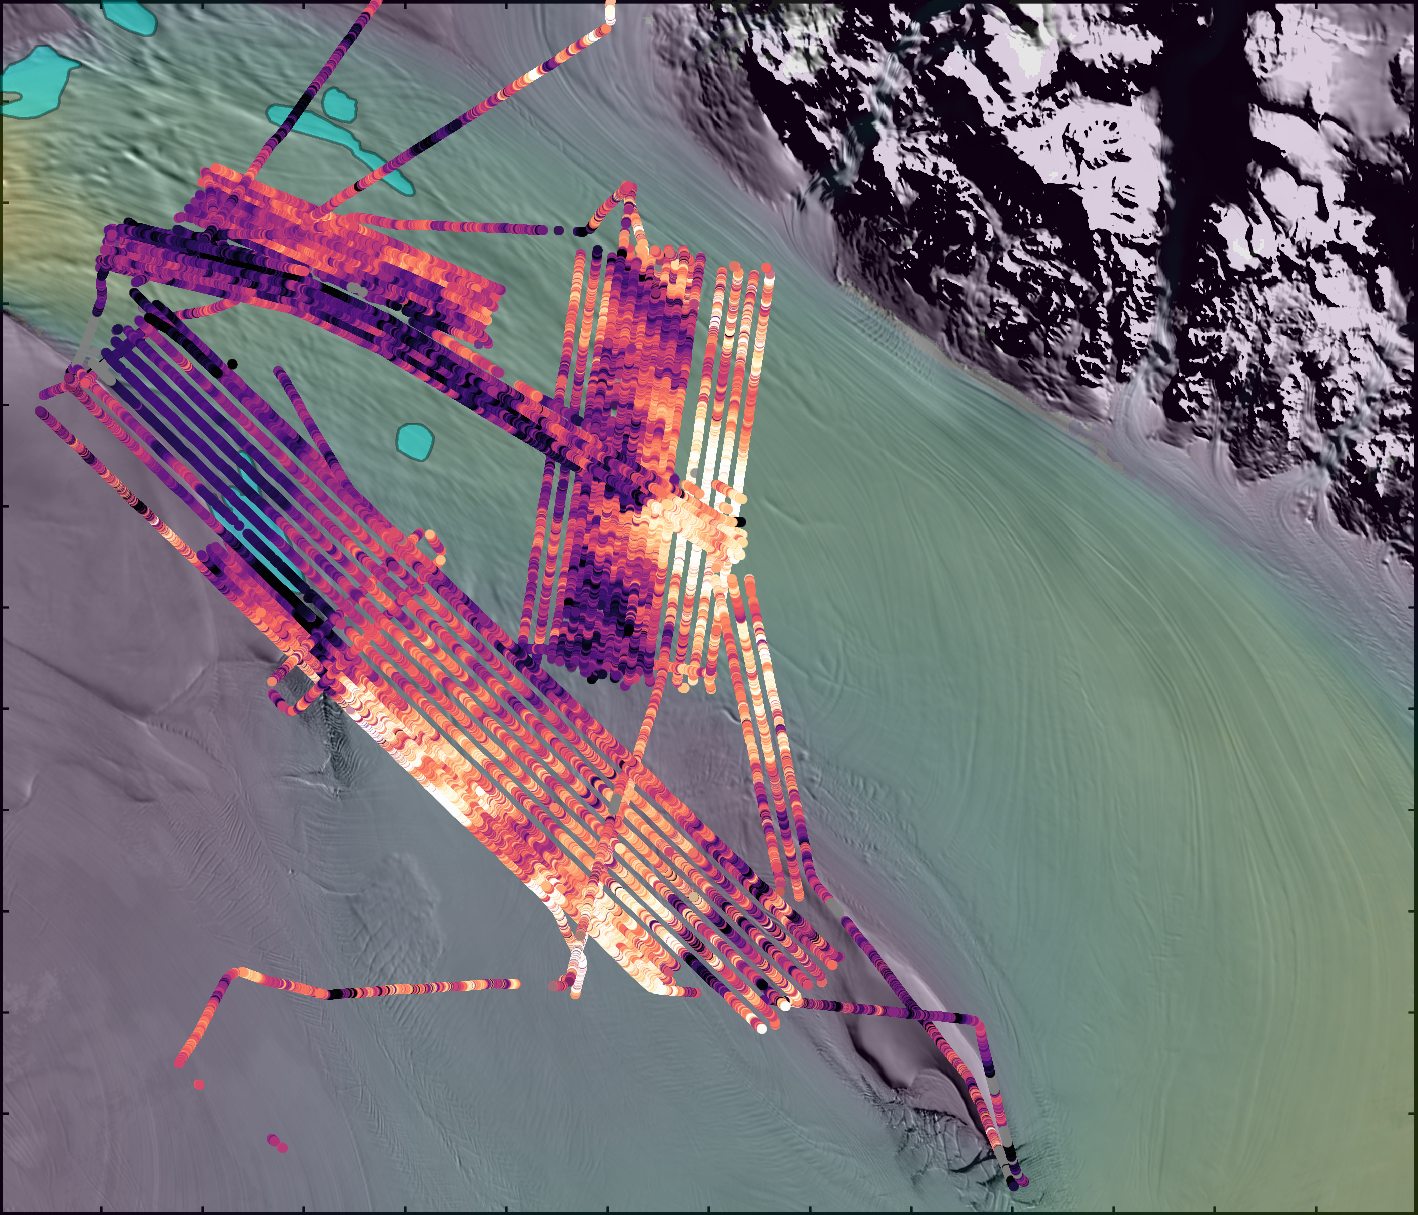

In [20]:
fig = pygmt.Figure()

if not quickplot:
    with pygmt.config(MAP_FRAME_TYPE = 'inside'):
        fig.grdimage(region = wipreg, projection = wipproj, frame=["nwse", "xf25000", "yf25000"], 
                     grid = moa, cmap = 'moa.cpt')

    veldata = xr.open_dataset(vel)
    vel_mag = (veldata['VX']**2 + veldata['VY']**2)**0.5
    fig.grdimage(region = wipreg, projection = wipproj, 
                 grid = vel_mag, cmap = 'vel.cpt', transparency = 80)

## plot the subglacial lakes
fig.plot(region = wipreg, projection = wipproj, 
         data = gdf, pen = "0.5p,black", fill = 'cyan', transparency = 60)
    
# plot the calculated relative reflectivity
sub = 1
if not quickplot:
    fig.plot(x=R_df['X'][::sub], y=R_df['Y'][::sub], fill=R_df['Relative Reflectivity'][::sub],
             cmap="power.cpt", style="c0.075c", transparency = 80)

fig.show()

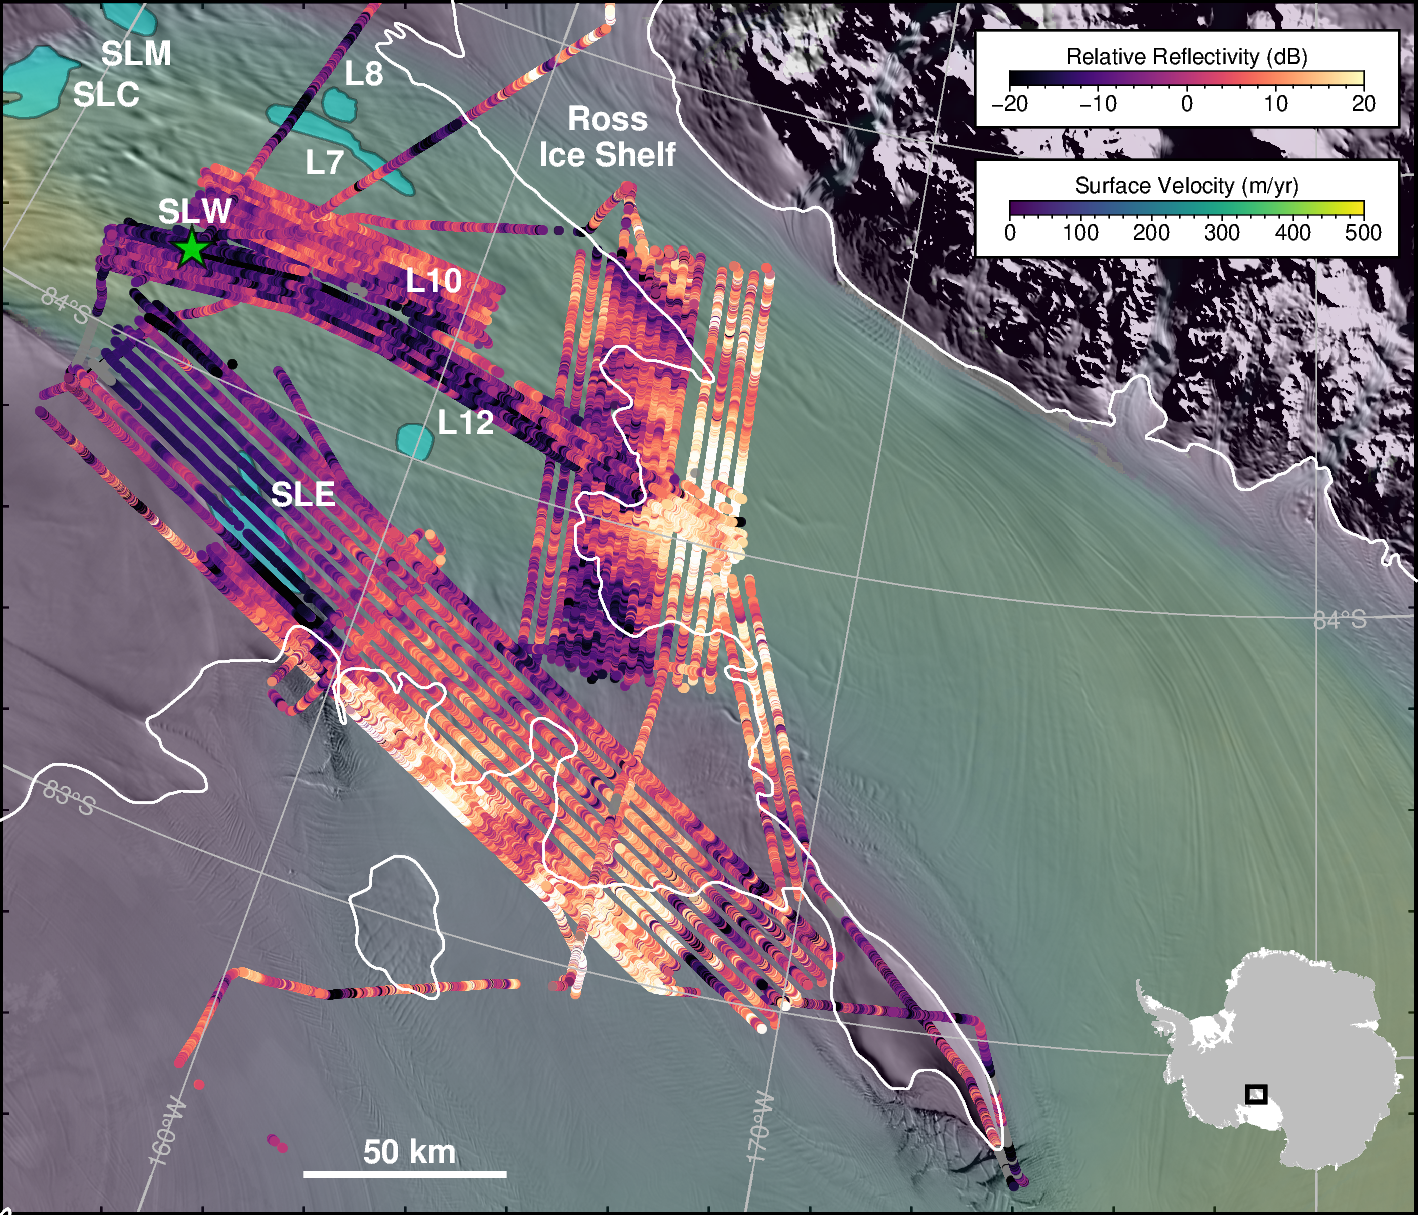

In [21]:
# put some niceities on the map

# Plot graticules overtop, at 2d latitude and 15d longitude
with pygmt.config(MAP_ANNOT_OFFSET_PRIMARY = '-2p', MAP_FRAME_TYPE = 'inside',
                   MAP_ANNOT_OBLIQUE = 0, FONT_ANNOT_PRIMARY = '6p,grey',
                   MAP_GRID_PEN_PRIMARY = 'grey', MAP_TICK_LENGTH_PRIMARY = '-10p',
                   MAP_TICK_PEN_PRIMARY = 'thinner,grey', FORMAT_GEO_MAP = 'dddF',
                   MAP_POLAR_CAP = '90/90'):
    fig.basemap(projection = wipproj_ll, region=wipreg_ll, frame = ["SnWE", "xa10g10", "ya1g1"])

# plot a star over the SLW borehole access site from WISSARD (Priscu et al., 2014)
fig.plot(x = wissard['x'], y = wissard['y'], fill = 'green', pen = '0.5,black', style = 'a0.15i', transparency = 20,
        region = wipreg, projection = wipproj)

## plot the grounding line
fig.plot(data = df_gl, pen = '0.5p,white')

#######
## Plot scale bar in lower left
wid = 50000 # scale bar width, in m
xoff = 75000 # distance from left to put scale bar, in m
yoff = 10000 # distance from bottom to put scale bar, in m

xleft = xoff
xmid = xoff + wid/2
xright = xoff + wid

fig.plot(x = [wip['xlow'] + xleft, wip['xlow'] + xright], 
         y = [wip['ylow'] + yoff, wip['ylow']+ yoff], pen = '1.5p,white')
fig.text(x = wip['xlow'] + xmid, y = wip['ylow'] + yoff, text = '{:3.0f}'.format(wid/1000) + ' km', 
         font = '8p,Helvetica-Bold,white', justify = 'BC', offset = '0/0.1c')

# plot letter in upper right (9 pt helvetica)
fig.text(x = wip['xlow'], y = wip['xhigh'], text = 'a', 
         font = '9p,Helvetica-Bold,white', justify = 'TL', offset = '0.1c/-0.1c')

# plot labels on features
!echo -175000 -529000 0 MC Ross > tmptxt
!echo -175000 -538000 0 MC Ice Shelf >> tmptxt
!echo -286000 -555000 0 BL SLW >> tmptxt
!echo -307000 -520000 0 TL SLC >> tmptxt
!echo -300000 -510000 0 TL SLM >> tmptxt
!echo -295500 -495000 0 BL SLM >> tmptxt
!echo -258000 -625000 0 BL SLE >> tmptxt
!echo -240000 -537000 0 TR L7 >> tmptxt
!echo -240000 -521000 0 BL L8 >> tmptxt
!echo -225000 -572000 0 BL L10 >> tmptxt
!echo -217000 -607000 0 BL L12 >> tmptxt
!echo -350000 -552000 20 TL Whillans Ice Stream >> tmptxt
!echo -338000 -451000 -40 TL Mercer Ice Stream >> tmptxt
fig.text(textfiles = 'tmptxt', font = '8p,Helvetica-Bold,white', angle=True, justify = True)
os.remove('tmptxt')
#######

# make the velocity colorbar 20% figure length, in the upper right
barwidth = figwidth/10 * 0.25
pos_str = 'n1/1+w' + str(barwidth) + 'c+h+ml+jTR+o0.45c/0.6c'
with pygmt.config(FONT_ANNOT_PRIMARY = '12p', FONT_LABEL = '12p', 
                  MAP_ANNOT_OFFSET_PRIMARY = '2p', MAP_TICK_PEN_PRIMARY = '0.5p', 
                  MAP_TICK_LENGTH_PRIMARY = '3p', MAP_FRAME_PEN = '0.5p', MAP_LABEL_OFFSET = '4p'):
    fig.colorbar(cmap = 'power.cpt', position = pos_str, frame = 'xa10f2+l"Relative Reflectivity (dB)"', box = '+gwhite+p0.5p')
#######

# make the velocity colorbar 20% figure length, in the upper right
barwidth = figwidth/10 * 0.25
pos_str = 'n1/1+w' + str(barwidth) + 'c+h+ml+jTR+o0.45c/1.7c'
with pygmt.config(FONT_ANNOT_PRIMARY = '12p', FONT_LABEL = '12p', 
                  MAP_ANNOT_OFFSET_PRIMARY = '2p', MAP_TICK_PEN_PRIMARY = '0.5p', 
                  MAP_TICK_LENGTH_PRIMARY = '3p', MAP_FRAME_PEN = '0.5p', MAP_LABEL_OFFSET = '4p'):
    fig.colorbar(cmap = 'vel.cpt', position = pos_str, box = '+gwhite+p0.5p', frame = 'xa100f20+l"Surface Velocity (m/yr)"')
#######

# Make insets
antwidth = 2.5 # width of inset in cm
antreg = '-2900000/-2900000/2900000/2900000r'
antmap = 'X' + str(antwidth) + 'c'

# generate offset string based on inset width
xoff_str = str(figwidth/10 - antwidth - 0.05) + 'c'
yoff_str = str(0.05) + 'c'

fig.shift_origin(xshift = xoff_str, yshift = yoff_str)
fig.basemap(projection = antmap, region = antreg, frame = '+n')
fig.plot(data = moa_coast, fill = 'white')
fig.plot(data = moa_gl, fill = 'gray')
fig.plot(x = [wip['xlow'], wip['xlow'], wip['xhigh'], wip['xhigh'], wip['xlow']], 
         y = [wip['ylow'], wip['yhigh'], wip['yhigh'], wip['ylow'], wip['ylow']], 
         pen = '1p,black')


fig.show()

In [22]:
os.remove('moa.cpt')
os.remove('vel.cpt')
os.remove('power.cpt')
# save
fig.savefig(out)